# *Лабораторная работа №2*

## Построение бинарного классификатора (Теоретическая часть)

Мы продолжаем работу над датасетом с данными о проданных подержанных автомобилях в Германии в 2016 году. В рамках текущей лабораторной необходимо построить модель бинарного классификатора, который бы позволил определить была ли машина в ремонте или нет. 


Подключим все необходимые для дальнейшей работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras import models
from keras import layers

import warnings
warnings.filterwarnings("ignore")

Загрузим базу данных, которая была получена нами в ходе предыдущей работы, т.е. в ней уже проведена определенная работа по очистке данных (подробнее см. лаб1). 

In [2]:
%%capture
!wget https://www.dropbox.com/s/s1sqfsi6x7hbs28/autos_mod.csv

Записываем ее в датафрейм и проверим столбцы на наличие пустых значений.

In [3]:
df = pd.read_csv('autos_mod.csv', encoding='iso-8859-1')
df.isnull().any()

Unnamed: 0            False
price                 False
vehicleType            True
yearOfRegistration    False
gearbox                True
powerPS               False
model                  True
kilometer             False
fuelType               True
brand                 False
notRepairedDamage      True
dtype: bool

Удалим столбец, который возник в процессе переписывания набора данных, так как никакой полезной информации он не несет.

In [4]:
del df["Unnamed: 0"]

Воспользуемся самым ленивым способом восстановления данных и очистим все столбцы от пустых значений, чтобы работать с исключительно неповрежденными записями.

In [5]:
df = df.drop(df[pd.isnull(df['vehicleType'])].index)
df = df.drop(df[pd.isnull(df['gearbox'])].index)
df = df.drop(df[pd.isnull(df['model'])].index)
df = df.drop(df[pd.isnull(df['fuelType'])].index)
df = df.drop(df[pd.isnull(df['notRepairedDamage'])].index)

Проверим, что у нас не осталось записей с пустыми значениями.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250919 entries, 2 to 329656
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               250919 non-null  int64 
 1   vehicleType         250919 non-null  object
 2   yearOfRegistration  250919 non-null  int64 
 3   gearbox             250919 non-null  object
 4   powerPS             250919 non-null  int64 
 5   model               250919 non-null  object
 6   kilometer           250919 non-null  int64 
 7   fuelType            250919 non-null  object
 8   brand               250919 non-null  object
 9   notRepairedDamage   250919 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.1+ MB


В нашем наборе данных достаточно большое количество полей типа object. Для того, чтобы с ними можно было работать, необходимо провести факторизацию, но сначала рассмотрим эти значения.

In [7]:
df['vehicleType'].unique()

array(['kleinwagen', 'limousine', 'cabrio', 'kombi', 'suv', 'bus',
       'coupe', 'andere'], dtype=object)

In [8]:
df['gearbox'].unique()

array(['manuell', 'automatik'], dtype=object)

In [9]:
df['model'].unique()

array(['golf', 'fabia', '3er', '2_reihe', 'andere', '3_reihe', 'passat',
       'navara', 'twingo', 'c_max', 'a_klasse', 'scirocco', '5er',
       'arosa', 'civic', 'transporter', 'punto', 'e_klasse', 'one',
       'clio', '1er', 'b_klasse', 'fortwo', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'scenic', 'a1', 'focus', 'tt', 'astra', 'a6', 'jazz',
       'polo', 'slk', '7er', 'combo', '80', '147', 'glk', 'meriva',
       'z_reihe', 'ibiza', 'mustang', 'eos', 'a4', 'touran', 'getz',
       'insignia', 'megane', 'a3', 'lupo', 'r19', 'colt', 'corsa',
       'vectra', 'berlingo', 'm_klasse', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', 'mondeo', '6er', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'omega', 'cuore',
       's_max', 'modus', 'a2', 'x_reihe', 'a5', 'galaxy', 'c3', 'viano',
       's_klasse', 'sharan',

In [10]:
df['fuelType'].unique()

array(['benzin', 'diesel', 'lpg', 'andere', 'hybrid', 'cng', 'elektro'],
      dtype=object)

In [11]:
df['notRepairedDamage'].unique()

array(['nein', 'ja'], dtype=object)

Для поля, которое нас интересует больше всего проверим соотношение количества записей, относящихся к разным классам.

In [12]:
df['notRepairedDamage'].value_counts()

nein    225322
ja       25597
Name: notRepairedDamage, dtype: int64

Отношение 1 к 10 не является хорошим, так как обеспечивает перевес объектов одного класса. Данный момент можно попытаться обойти, уравновесив выборки по принадлежности к классам. В рамках данной методички продолжим обучение на необработанной выборке.

Проведем факторизацию и проверим результат ее исполнения.

In [13]:
names = ['vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']
for name in names:
    df[name] = pd.factorize(df[name])[0]
df.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
2,1500,0,2001,0,75,0,150000,0,0,0
3,3600,0,2008,0,69,1,90000,1,1,0
4,650,1,1995,0,102,2,150000,0,2,1
5,2200,2,2004,0,109,3,150000,0,3,0
6,0,1,1980,0,50,4,40000,0,0,0


Как мы можем видеть, в результате удаления части значений из базы данных, произошло нарушение следования индексов. В рамках нашей задачи данный аспект некритичен, но все же произведемсброс индексации.

In [14]:
df = df.reset_index(drop=True)
df.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,1500,0,2001,0,75,0,150000,0,0,0
1,3600,0,2008,0,69,1,90000,1,1,0
2,650,1,1995,0,102,2,150000,0,2,1
3,2200,2,2004,0,109,3,150000,0,3,0
4,0,1,1980,0,50,4,40000,0,0,0


Проверим, как стали выглядеть исследуемые классы после факторизации.

In [15]:
df['notRepairedDamage'].value_counts()

0    225322
1     25597
Name: notRepairedDamage, dtype: int64

Разобьем весь наш набора данных на тренировочный и тестовый наборы данных.


*Вопрос на подумать:* Какое разбиение можно считать удачным при работе с подобным набором данных?

In [16]:
values = df['notRepairedDamage']
points = df.drop(['notRepairedDamage'], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

Создадим достаточно простенькую модель из 10 решающих деревьев и оценим точность ее работы.

In [17]:
rf_model = ensemble.RandomForestClassifier(n_estimators=10)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.9017415909453212


С одной стороны, точность работы классификатора, близкая к 90% - хороший показатель. С другой стороны, не будем забывать о том, что распределение классов в нашем датасете неравномерное. Поэтому проведем сравнение с константным классификатором.

In [18]:
print(accuracy_score(test_values, np.zeros_like(test_values)))

0.8962019767256496


Классификатор, который абсолютно все объекты относит к одному и тому же классу, работает с сопоставимой точностью. В этом и состоит основная сложность работы с несбалансированными наборами данных. Попробуем увеличить количество деревьев в модели.

In [19]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.9044715447154471


Увеличение количества деревьев привело к улучшению результата, но от идеала он по-прежнему далек. В качестве альтернативы попробуем использовать аппарат искусственных нейронных сетей.

In [20]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 5,
 batch_size = 1000,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/5
201/201 [==============================] - 2s 5ms/step - loss: 2444.7997 - accuracy: 0.6482 - val_loss: 20.0065 - val_accuracy: 0.8841
Epoch 2/5
201/201 [==============================] - 0s 2ms/step - loss: 28.2093 - accuracy: 0.8658 - val_loss: 9.0656 - val_accuracy: 0.8779
Epoch 3/5
201/201 [==============================] - 0s 2ms/step - loss: 15.2363 - accuracy: 0.8441 - val_loss: 9.3195 - val_accuracy: 0.8903
Epoch 4/5
201/201 [==============================] - 0s 2ms/step - loss: 26.8303 - accuracy: 0.8274 - val_loss: 7.8010 - val_accuracy: 0.6863
Epoch 5/5
201/201 [==============================] - 0s 2ms/step - loss: 16.8166 - accuracy: 0.8242 - val_loss: 6.5716 - val_accuracy: 0.7179
Test-Accuracy: 0.8581114411354065


Данная модель демонстрирует крайнюю неустойчивость, так как при каждом запуске значение точности сильно разнится. Если мы уменьшим количество записей, обрабатываемых между корректировкой весов, то сможем получить более стабильный результат.

In [21]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 5,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/5
2008/2008 [==============================] - 4s 2ms/step - loss: 310.6361 - accuracy: 0.8477 - val_loss: 114.1321 - val_accuracy: 0.8881
Epoch 2/5
2008/2008 [==============================] - 3s 1ms/step - loss: 54.1608 - accuracy: 0.8470 - val_loss: 42.8218 - val_accuracy: 0.5458
Epoch 3/5
2008/2008 [==============================] - 3s 1ms/step - loss: 11.9075 - accuracy: 0.8338 - val_loss: 15.1858 - val_accuracy: 0.8959
Epoch 4/5
2008/2008 [==============================] - 3s 1ms/step - loss: 15.8551 - accuracy: 0.8337 - val_loss: 29.2616 - val_accuracy: 0.8935
Epoch 5/5
2008/2008 [==============================] - 2s 1ms/step - loss: 20.1742 - accuracy: 0.8334 - val_loss: 9.0880 - val_accuracy: 0.8962
Test-Accuracy: 0.842040479183197


Для окончательного закрепления результата увеличим количество эпох обучения до 10, чтобы кривая обучения успевала сходиться.

In [22]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 [==============================] - 3s 1ms/step - loss: 210.6662 - accuracy: 0.8463 - val_loss: 96.2220 - val_accuracy: 0.3031
Epoch 2/10
2008/2008 [==============================] - 3s 1ms/step - loss: 35.4270 - accuracy: 0.8301 - val_loss: 93.9948 - val_accuracy: 0.8927
Epoch 3/10
2008/2008 [==============================] - 3s 1ms/step - loss: 44.7562 - accuracy: 0.8349 - val_loss: 21.9092 - val_accuracy: 0.8950
Epoch 4/10
2008/2008 [==============================] - 3s 1ms/step - loss: 35.6032 - accuracy: 0.8326 - val_loss: 100.7135 - val_accuracy: 0.8910
Epoch 5/10
2008/2008 [==============================] - 3s 1ms/step - loss: 113.1892 - accuracy: 0.8487 - val_loss: 9.7817 - val_accuracy: 0.8940
Epoch 6/10
2008/2008 [==============================] - 3s 1ms/step - loss: 29.6188 - accuracy: 0.8301 - val_loss: 34.4445 - val_accuracy: 0.8586
Epoch 7/10
2008/2008 [==============================] - 3s 1ms/step - loss: 75.9437 - accuracy: 0.8501 - val_loss: 20.5988

Попробуем ввести дополнительный скрытый слой в сеть, чтобы упростить задачу классификации выходному слою нейронов.

In [23]:
model = models.Sequential()

model.add(layers.Dense(10, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 [==============================] - 4s 2ms/step - loss: 62.7066 - accuracy: 0.8338 - val_loss: 3.5245 - val_accuracy: 0.8930
Epoch 2/10
2008/2008 [==============================] - 3s 1ms/step - loss: 3.5671 - accuracy: 0.8339 - val_loss: 0.6537 - val_accuracy: 0.8962
Epoch 3/10
2008/2008 [==============================] - 3s 1ms/step - loss: 0.5044 - accuracy: 0.8980 - val_loss: 0.3490 - val_accuracy: 0.8962
Epoch 4/10
2008/2008 [==============================] - 3s 1ms/step - loss: 0.3369 - accuracy: 0.8988 - val_loss: 0.3335 - val_accuracy: 0.8962
Epoch 5/10
2008/2008 [==============================] - 3s 1ms/step - loss: 0.3265 - accuracy: 0.8994 - val_loss: 0.3334 - val_accuracy: 0.8962
Epoch 6/10
2008/2008 [==============================] - 3s 1ms/step - loss: 0.3281 - accuracy: 0.8986 - val_loss: 0.3334 - val_accuracy: 0.8962
Epoch 7/10
2008/2008 [==============================] - 3s 1ms/step - loss: 0.3299 - accuracy: 0.8978 - val_loss: 0.3334 - val_accuracy

Благодаря уменьшению количества нейронов на предпоследнем слое, нейронная сеть смогла с большей точностью определять ключевые компоненты и учитывать их при вынесении вердикта о принадлежности объекта тому или иному классу.

Ради интереса, попробуем ввести дополнительную метрику при обучении и оценим, насколька она меняет результат к лучшему.

In [24]:
from keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [25]:
model = models.Sequential()

model.add(layers.Dense(10, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy", rmse]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 [==============================] - 4s 2ms/step - loss: 166.4272 - accuracy: 0.8386 - rmse: 0.1616 - val_loss: 10.3521 - val_accuracy: 0.8960 - val_rmse: 0.1040
Epoch 2/10
2008/2008 [==============================] - 3s 2ms/step - loss: 12.4207 - accuracy: 0.8350 - rmse: 0.1652 - val_loss: 10.4412 - val_accuracy: 0.8961 - val_rmse: 0.1040
Epoch 3/10
2008/2008 [==============================] - 3s 1ms/step - loss: 62.4232 - accuracy: 0.8266 - rmse: 0.1735 - val_loss: 1.7597 - val_accuracy: 0.8937 - val_rmse: 0.1066
Epoch 4/10
2008/2008 [==============================] - 3s 1ms/step - loss: 13.2213 - accuracy: 0.8319 - rmse: 0.1686 - val_loss: 3.5279 - val_accuracy: 0.8960 - val_rmse: 0.1040
Epoch 5/10
2008/2008 [==============================] - 3s 1ms/step - loss: 10.3281 - accuracy: 0.8304 - rmse: 0.1699 - val_loss: 3.3842 - val_accuracy: 0.8876 - val_rmse: 0.1091
Epoch 6/10
2008/2008 [==============================] - 3s 1ms/step - loss: 3.2682 - accuracy: 0.8361 

Введение дополнительных метрик в процесс обучения может положительно сказаться на результате, но необходимо четко понимать назначение той или иной метрики. Для бинарного классификатора наиболее подходящей будет f-мера.

Кроме работы непосредственно с моделями и их составляющими, можно попробовать преобразовать данные для их лучшей интерпретируемости системой. В данном случае, поле года выпуска автомобиля имеет плохую форму распределения.

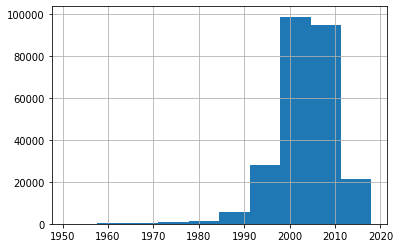

In [26]:
df['yearOfRegistration'].hist()

Введем вместо него поле с возрастом.

In [27]:
df['age'] = 2017 - df['yearOfRegistration']
del df['yearOfRegistration']
df.head()

,price,vehicleType,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,age
0,1500,0,0,75,0,150000,0,0,0,16
1,3600,0,0,69,1,90000,1,1,0,9
2,650,1,0,102,2,150000,0,2,1,22
3,2200,2,0,109,3,150000,0,3,0,13
4,0,1,0,50,4,40000,0,0,0,37


In [28]:
values = df['notRepairedDamage']
points = df.drop(['notRepairedDamage'], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

In [29]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

0.9061653116531165


In [30]:
model = models.Sequential()

model.add(layers.Dense(9, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Epoch 1/10
2008/2008 [==============================] - 3s 1ms/step - loss: 84.1177 - accuracy: 0.8891 - val_loss: 0.3767 - val_accuracy: 0.8985
Epoch 2/10
2008/2008 [==============================] - 3s 1ms/step - loss: 0.3560 - accuracy: 0.8974 - val_loss: 0.3293 - val_accuracy: 0.8985
Epoch 3/10
2008/2008 [==============================] - 3s 1ms/step - loss: 0.3309 - accuracy: 0.8975 - val_loss: 0.3283 - val_accuracy: 0.8985
Epoch 4/10
2008/2008 [==============================] - 3s 1ms/step - loss: 0.3329 - accuracy: 0.8964 - val_loss: 0.3283 - val_accuracy: 0.8985
Epoch 5/10
2008/2008 [==============================] - 3s 1ms/step - loss: 0.3263 - accuracy: 0.8994 - val_loss: 0.3284 - val_accuracy: 0.8985
Epoch 6/10
2008/2008 [==============================] - 3s 1ms/step - loss: 0.3286 - accuracy: 0.8984 - val_loss: 0.3283 - val_accuracy: 0.8985
Epoch 7/10
2008/2008 [==============================] - 3s 1ms/step - loss: 0.3291 - accuracy: 0.8981 - val_loss: 0.3283 - val_accuracy

Для обеих моделей мы получили увеличение точности. Попробуем пойти еще немного дальше, объединив два поля в одно. Такой подход называют уменьшением размерности, так как он позволяет работать с входным вектором меньшего размера.

In [31]:
df['intence'] = df['kilometer']/df['age']
del df['kilometer']
del df['age']

In [32]:
values = df['notRepairedDamage']
points = df.drop(['notRepairedDamage'], axis=1)
train_points, test_points, train_values, test_values = train_test_split(points, values, test_size = 0.2)

In [33]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
print(accuracy_score(test_values, test_predict_rf))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
model = models.Sequential()

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(15, activation = "relu"))

model.add(layers.Dense(8, activation = "relu"))

model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 100,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

Умменьшение размерности нашего входного вектора не привело к улучшению общей картины. Не всегда одни и те же шаги приводят к одному и тому же результату. Из-за специфики датасета действенность метода может очень сильно варьироваться.

## Построение бинарного классификатора (Практическая часть)

Вашим заданием в данной лабораторной будет построение бинарного классификатора для определения пола человека, пользуещегося смартфоном. Данное задание основано на данном датасете с kaggle (https://www.kaggle.com/pwang001/user-package-information-of-mobile-operators).

**Ограничения по реализации:**

*Случайный лес*: не более 100 деревьев.

*Нейронные сети*: не более трех скрытых слоев, не более 20 нейронов на одном слое. 

**Даже при использовании собственных метрик в процессе обучения. Итоговая оценка должна производиться по метрике *Accuracy*.**

In [ ]:
%%capture
!wget https://www.dropbox.com/s/5b6o99k5ko6cr1r/train_1.csv
!wget https://www.dropbox.com/s/br8m56fomdxs7lw/train_2.csv
!wget https://www.dropbox.com/s/xmw5shslewwfi0n/test_1.csv
!wget https://www.dropbox.com/s/uxxc48au1zclpu2/test_2.csv

### Загрузка данных

In [78]:
df1_train = pd.read_csv('train_1.csv')
#df2_train = pd.read_csv('train_2.csv')
#df_train = pd.concat([df1_train, df2_train])
df_train = df1_train


#df1_test = pd.read_csv('test_1.csv')
#df2_test = pd.read_csv('test_1.csv')
#df_test = pd.concat([df1_test, df2_test])

#dfs = [df_train, df_test]
dfs = [df_train]


n = df_train['gender'].unique()[-1]

for df in dfs:
    df.drop('user_id', axis=1, inplace=True)
    df.drop('former_complaint_fee', axis=1, inplace=True) #???
    
    df.drop(df[df['gender'] == n].index, inplace=True)
    df.drop(df[df['age'] == n].index, inplace=True)
    df.drop(df[df['2_total_fee'] == n].index, inplace=True)
    df.drop(df[df['3_total_fee'] == n].index, inplace=True)
    
    df['2_total_fee'] = df['2_total_fee'].astype('float64')
    df['3_total_fee'] = df['2_total_fee'].astype('float64')
    
    df.drop(df[df['gender'] == 0].index, inplace=True)
    df.drop(df[df['gender'] == '0'].index, inplace=True)
    df.drop(df[df['gender'] == '00'].index, inplace=True)
    
    df['gender'] = df['gender'].astype('int')
    df['age'] = df['age'].astype('int')
    
df_train = dfs[0]
#df_test = dfs[1]

In [79]:
df_train.head(3)

,service_type,is_mix_service,online_time,1_total_fee,2_total_fee,3_total_fee,4_total_fee,month_traffic,many_over_bill,contract_type,...,last_month_traffic,local_trafffic_month,local_caller_time,service1_caller_time,service2_caller_time,gender,age,complaint_level,former_complaint_num,current_service
0,4,0,85,295.96,296.2,296.2,296.8,3813.614698,0,1,...,4096.0,1392.038508,108.100000,0.000000,564.366667,1,31,0,0,99999825
1,1,0,10,265.20,261.2,261.2,174.5,0.000000,1,0,...,0.0,62852.509718,240.100000,355.166667,0.000000,1,30,0,0,90063345
2,1,0,12,44.50,70.2,70.2,61.4,2598.397406,0,0,...,0.0,1935.242104,27.666667,0.000000,98.416667,2,25,0,0,90109916


In [80]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721076 entries, 0 to 743989
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   service_type            721076 non-null  int64  
 1   is_mix_service          721076 non-null  int64  
 2   online_time             721076 non-null  int64  
 3   1_total_fee             721076 non-null  float64
 4   2_total_fee             721076 non-null  float64
 5   3_total_fee             721076 non-null  float64
 6   4_total_fee             721076 non-null  float64
 7   month_traffic           721076 non-null  float64
 8   many_over_bill          721076 non-null  int64  
 9   contract_type           721076 non-null  int64  
 10  contract_time           721076 non-null  int64  
 11  is_promise_low_consume  721076 non-null  int64  
 12  net_service             721076 non-null  int64  
 13  pay_times               721076 non-null  int64  
 14  pay_num             

In [67]:
# Категориальные и числовые признаки

cat_features = ['service_type', 'is_mix_service', 'many_over_bill',
                'is_promise_low_consume', 'gender', 'complaint_level',
                'contract_type', 'net_service']

num_features = set(df_train.columns) - set(cat_features)

len(num_features), len(cat_features), len(df_train.columns)

(17, 8, 25)

In [31]:
y = df_train['gender'].values
X = df_train.drop('gender', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [32]:
# Тупо случайный лес - 10 деревьев
rf_10 = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=1)
rf_10.fit(X_train, y_train)

y_pred_10 = rf_10.predict(X_test)
print('f1 score (10 деревьев):', round(f1_score(y_test, y_pred_10), 4))
print('Accuracy (10 деревьев):', round(accuracy_score(y_test, y_pred_10), 4))

f1 score (10 деревьев): 0.8242
Accuracy (10 деревьев): 0.7232


In [7]:
# Тупо случайный лес - 50 деревьев
rf_50 = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=1)
rf_50.fit(X_train, y_train)

y_pred_50 = rf_50.predict(X_test)
print('f1 score (50 деревьев):', round(f1_score(y_test, y_pred_50), 4))
print('Accuracy (50 деревьев):', round(accuracy_score(y_test, y_pred_50), 4))

f1 score (50 деревьев): 0.8356
Accuracy (50 деревьев): 0.7371


In [8]:
# Тупо случайный лес - 100 деревьев
rf_100 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
rf_100.fit(X_train, y_train)

y_pred_100 = rf_100.predict(X_test)
print('f1 score (100 деревьев):', round(f1_score(y_test, y_pred_100), 4))
print('Accuracy (100 деревьев):', round(accuracy_score(y_test, y_pred_100), 4))

f1 score (100 деревьев): 0.8371
Accuracy (100 деревьев): 0.7385


In [ ]:
sns.pairplot(df_train[:200])

In [45]:
#fees = df_train['1_total_fee'] + df_train['2_total_fee'] + df_train['3_total_fee'] + df_train['4_total_fee']

In [51]:
df_train['former_complaint_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  9,  8,  6, 16, 11,  7, 10, 13, 17, 19, 12,
       15, 14, 22, 20], dtype=int64)